# Advanced data manipulation with Geolabel Maker &nbsp; [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/makinacorpus/geolabel-maker/blob/master/notebooks/Generate%20a%20dataset%20with%20Geolabel%20%Maker.ipynb)

A tutorial provided by [Makina Corpus](https://makina-corpus.com/)  

In this tutorial, we will see the inner structure of rasters and categories, and how to process them. 

This tutorial will covers the following sections:

**1. `Raster`: Insight of the raster architecture**

**2. `Category`: Insight of the category architecture**

**3. `Dataset`: Insight of the dataset architecture**

**4. Data processing for all `GeoBase` objects**

In [1]:
%load_ext autoreload
%autoreload 2

## Set Up

As always, we will load the required packages to generate a dataset. We will add ``geolabel_maker`` package to the path,
to make sure you can access its modules.  
As this notebook is available on google colaboratory, we need to load GDAL and other packages differently.

In [2]:
import sys
import os

RUN_ON_COLAB = False

# Check if its running from Colab
if "google.colab" in str(get_ipython()):
    RUN_ON_COLAB = True
    print("Running on Google Colab")
else:
    print("Running on Jupyter")

Running on Jupyter


### For Jupyter users

The following code will load packages for Notebook users. Keep in mind that GDAL and other packages must be installed.

In [3]:
if not RUN_ON_COLAB:
    sys.path.append("../")

### For Colab users

In [4]:
if RUN_ON_COLAB:
    # Install GDAL
    !apt install gdal-bin python-gdal python3-gdal 
    # Install rasterio
    !pip install rasterio
    # Install rtree (required by geopandas)
    !apt install python3-rtree 
    # Install geopandas
    !pip install git+git://github.com/geopandas/geopandas.git
    # Install geopandas (required by geopandas)
    !pip install descartes
    # Install GDAL2TILES
    !pip install gdal2tiles
    # Import SentinelSat from ESA Copernicus program
    !pip install sentinelsat
    # OSM to geojson converter
    !pip install osmtogeojson
    # Install OpenCV for fast segmentation
    !pip install opencv-python
    # Install Geolabel Maker
    !git clone -b projinfo-dev https://github.com/makinacorpus/geolabel-maker
    sys.path.append("/content/geolabel-maker")

    # Sanity check to know if GDAL is correctly installed.
    # SKipping this step may raise errors like:
    # CPLE_AppDefinedError: PROJ: proj_create from database: Cannot find proj.db

    import rasterio
    filename = "http://landsat-pds.s3.amazonaws.com/c1/L8/003/065/LC08_L1TP_003065_20190925_20191017_01_T1/LC08_L1TP_003065_20190925_20191017_01_T1_B4.TIF"
    rasterio.open(filename)

### Imports

In [5]:
# Basic imports
from pathlib import Path
import requests
import json
import rasterio
import geopandas as gpd

# Geolabel Maker
from geolabel_maker import Dataset
from geolabel_maker.rasters import Raster, RasterCollection
from geolabel_maker.vectors import Category, CategoryCollection
from geolabel_maker.annotations import Segmentation, ObjectDetection, Classification

### Speedups

Some users can experience issues related to ``shapely``. To fix it, simply use ``speedups.disable()``

In [6]:
# Disable speedups for windows users because they can experience errors
if os.name == "nt":
    from geolabel_maker import speedups
    
    speedups.disable()

## Data Set Up

For this tutorial, we will use the same data from [Grand Lyon website](https://data.grandlyon.com) as in [Generate annotations with Geolabel Maker](Generate%20annotations%20with%20Geolabel%20Maker.ipynb) notebook.

In [7]:
def download_image(url, out_file):
    """Download data from an url.
    
    Args:
        url (str): URL used to request data.
        out_file (str): Name of the output file.
    """
    Path(out_file).parent.mkdir(parents=True, exist_ok=True)
    with open(out_file, "wb") as handle:
        response = requests.get(url, stream=True)
        for block in response.iter_content(1024):
            if not block:
                break
            handle.write(block)
    

def download_vector(url, out_file):
    """Download vector from an url.
    
    Args:
        url (str): URL used to request data.
        out_file (str): Name of the output file.
    """
    Path(out_file).parent.mkdir(parents=True, exist_ok=True)
    with open(out_file, "w") as handle:
        response = requests.get(url, stream=True)
        json.dump(response.json(), handle)

### Download images

Then, we will download the images and save them under ``data/images`` directory.

In [8]:
# Download 1843_5173_08_CC46 tile
url = "https://download.data.grandlyon.com/files/grandlyon/imagerie/ortho2018/ortho/GeoTiff_YcBcR/1km_8cm_CC46/1843_5173_08_CC46.tif"
download_image(url, out_file="data/images/1843_5173_08_CC46.tif")

# Download 1844_5173_08_CC46 tile
url = "https://download.data.grandlyon.com/files/grandlyon/imagerie/ortho2018/ortho/GeoTiff_YcBcR/1km_8cm_CC46/1844_5173_08_CC46.tif"
download_image(url, out_file="data/images/1844_5173_08_CC46.tif")

### Download vectors

We do the same for the vectors, except we save them under ``data/categiries`` directory.

In [9]:
# Download buildings
url = "https://raw.githubusercontent.com/makinacorpus/geolabel-maker/projinfo-dev/data/categories/buildings.json"
download_vector(url, out_file="data/categories/buildings.json")

# Download vegetation
url = "https://raw.githubusercontent.com/makinacorpus/geolabel-maker/projinfo-dev/data/categories/vegetation.json"
download_vector(url, out_file="data/categories/vegetation.json")

## Raster

The `Raster` class relies on `GDAL` and `rasterio`.
It provides tools to process raster data.

### Open

To open a raster, use the `open` method. You will need to provide the path to the file you want to open.

In [10]:
image = Raster.open("data/images/1843_5173_08_CC46.tif")
image

Raster(filename='data\images\1843_5173_08_CC46.tif', bounds=(1843000.0, 5173000.0, 1844000.0, 5174000.0), crs=EPSG:3946)

The `Raster` have a `data` attribute, which corresponds to a `rasterio.DatasetReader` object.
For in-memory rasters, this attribute is a `rasterio.io.DatasetWriter` object.

In [11]:
image_data = image.data
image_data

<closed DatasetReader name='data/images/1843_5173_08_CC46.tif' mode='r'>

Notice that the ``rasterio.DatasetReader`` is closed. You can easily open it using ``to_rasterio`` method:

In [12]:
image_data = image.rasterio()
image_data

<open DatasetReader name='data/images/1843_5173_08_CC46.tif' mode='r'>

To close the raster, use the ``close`` method from ``rasterio``. Alternatively, you could use a `with` statement to open and close a raster.

```python
with image.rasterio() as raster_data:
    # Do some stuff
```

It is recommended to always close rasters.

In [13]:
image_data.close()
image_data

<closed DatasetReader name='data/images/1843_5173_08_CC46.tif' mode='r'>

### Rasterio

Because the ``Raster`` class is contains a ``rasterio.DatasetReader`` or ``rasterio.DatasetWriter``, you can create a raster from such data like.

In [14]:
filename = "data/images/1843_5173_08_CC46.tif"

with rasterio.open(filename, "r") as raster_data:
    raster = Raster(raster_data, filename=filename)

Because we used a ``with`` statement, the ``DatasetReader`` in the ``Raster`` is closed.

In [15]:
raster.data

<closed DatasetReader name='data/images/1843_5173_08_CC46.tif' mode='r'>

## Category

In ``geolabel-maker``, vectors are often called categories. A category must have a name and color.
This class relies on `geopandas` and `pyproj`.

### Open

To open a category use the `open` method. You can provide optional arguments such as `name` and `color`.

In [16]:
buildings = Category.open("data/categories/buildings.json", name="buildings", color="lightgrey")
buildings

Category(filename='data\categories\buildings.json', data=GeoDataFrame(6130 rows, 3 columns), name='buildings', color=(211, 211, 211), crs=EPSG:3946)

If the argument ``name`` is not provided, the default one will be the file's name. If the `color` is not provided, a random one will be generated.

In [17]:
vegetation = Category.open("data/categories/vegetation.json")
vegetation

Category(filename='data\categories\vegetation.json', data=GeoDataFrame(38 rows, 27 columns), name='vegetation', color=(206, 141, 126), crs=EPSG:3946)

The ``Category`` have a ``data`` attribute which corresponds to a ``geopandas.GeoDataFrame`` object.

In [18]:
vegetation.data.head()

,uid,id_ariane,nom,num,numvoie,voie,codepost,commune,code_insee,reglement,...,label,type_equip,eau,toilettes,chien,esp_can,photo,gid,ann_ouvert,geometry
0,PAR-69387-57233,S8199,Berges du Rhône 7e,57233,1,Berge du Rhône 7e,69007,Lyon,69387,Oui,...,Non,Aire de jeux-Fontaine-Espace ludique,Oui,Non,Oui,Non,0,71,None,"POLYGON ((1841971.660 5172496.720, 1841976.450..."
1,PAR-69383-03390,S8358,Esplanade Nelson Mandela,3390,128,Av Félix Faure,69003,Lyon,69383,Oui,...,Non,Aire de jeux-Fontaine,Oui,Oui,Oui,Oui,0,74,None,"POLYGON ((1845012.240 5174011.930, 1845012.410..."
2,PAR-69383-03425,S8332,Jardin Abbé Boisard,3425,133,Cours Gambetta,69003,Lyon,69383,Oui,...,Non,,Non,Non,Non,Non,0,75,None,"POLYGON ((1844498.200 5173951.000, 1844559.320..."
3,PAR-69383-03358,S8355,Jardin Château sans souci,3358,3,Rue des Cadets de la France Libre,69003,Lyon,69383,Oui,...,Non,Aire de jeux,Oui,Non,Non,Non,0,85,None,"POLYGON ((1845215.820 5174281.220, 1845234.120..."
4,PAR-69388-08254,S8401,Jardin de la Laïcité,8254,123,Rue Marius Berliet,69008,Lyon,69388,Oui,...,Non,Aire de jeux,Non,Non,Non,Non,0,98,None,"POLYGON ((1845280.270 5172675.550, 1845288.250..."


You may experience errors using `geopandas`. For example, on Google Colab the CRS is incorrectly retrieved, and must be set manually.

In [19]:
if RUN_ON_COLAB:
    categories[0].data = categories[0].data.set_crs("EPSG:3946", allow_override=True)
    categories[1].data = categories[1].data.set_crs("EPSG:3946", allow_override=True)

## Data Preparation

This section will guide you on how to process and convert data.

The process methods are available for all your `GeoBase` objects, like:

- `Raster`
- `Category`
- `RasterCollection`
- `CategoryCollection`
- `Dataset`

All this objects share the same interface, and the methods behave similarly.

### Overwrite

You can overwrite the data you are processing with the `overwrite` argument. Even though this argument can be useful, we recommend to use it only if you don't have other objects referencing to the same file.

The issue you may face if you overwrite an element is that other objects pointing to the same file won't be changed.

### Bounds

You can visualize the bounds of your objects with `plot_bounds` method, or simply through the `bounds` attribute.

In [20]:
image.bounds

BoundingBox(left=1843000.0, bottom=5173000.0, right=1844000.0, top=5174000.0)

<AxesSubplot:title={'center':'Bounds of the Raster'}>

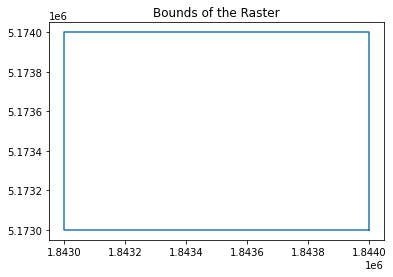

In [21]:
image.plot_bounds()

### Coordinate Reference System

A `GeoBase` must have a CRS attribute. Geolabel Maker uses the `CRS` implementation from `pyproj`.

You can change the coordinate reference system of your `GeoBase` obejcts (like `Raster`, `Category`, `Dataset`...) with the ``to_crs`` method.
The ``overwrite`` argument is used to replace the file(s) saved on disk with the output(s).

In [22]:
out_vegetation = vegetation.to_crs("EPSG:4326")
out_vegetation

Category(data=GeoDataFrame(38 rows, 27 columns), name='vegetation', color=(206, 141, 126), crs=EPSG:4326)

The output data does not have a file's name, because it was created in memory.

In [23]:
out_vegetation.filename

In [24]:
vegetation.crs

<Projected CRS: EPSG:3946>
Name: RGF93 / CC46
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: France - mainland onshore between 45°N and 47°N.
- bounds: (-2.21, 45.0, 7.16, 47.0)
Coordinate Operation:
- name: France Conic Conformal zone 5
- method: Lambert Conic Conformal (2SP)
Datum: Reseau Geodesique Francais 1993
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [25]:
out_vegetation.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

If you want to process and replace the data on your disk with the output use the `overwrite` argument.

In [26]:
out_vegetation = vegetation.to_crs("EPSG:4326", overwrite=True)
out_vegetation

Category(filename='data\categories\vegetation.json', data=GeoDataFrame(38 rows, 27 columns), name='vegetation', color=(206, 141, 126), crs=EPSG:4326)

In [27]:
out_vegetation.filename

'data\\categories\\vegetation.json'

In [28]:
vegetation.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [29]:
out_vegetation.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Crop

If the geographic extent of your categories or images is too large, you can crop the data with ``crop``. This method also have an ``overwrite`` argument to replace file(s) saved on disk(s) with the output(s).

In [30]:
out_buildings = buildings.crop(image.bounds)
out_buildings

Category(data=GeoDataFrame(1384 rows, 3 columns), name='buildings', color=(211, 211, 211), crs=EPSG:3946)

<AxesSubplot:title={'center':'Bounds of the Category'}>

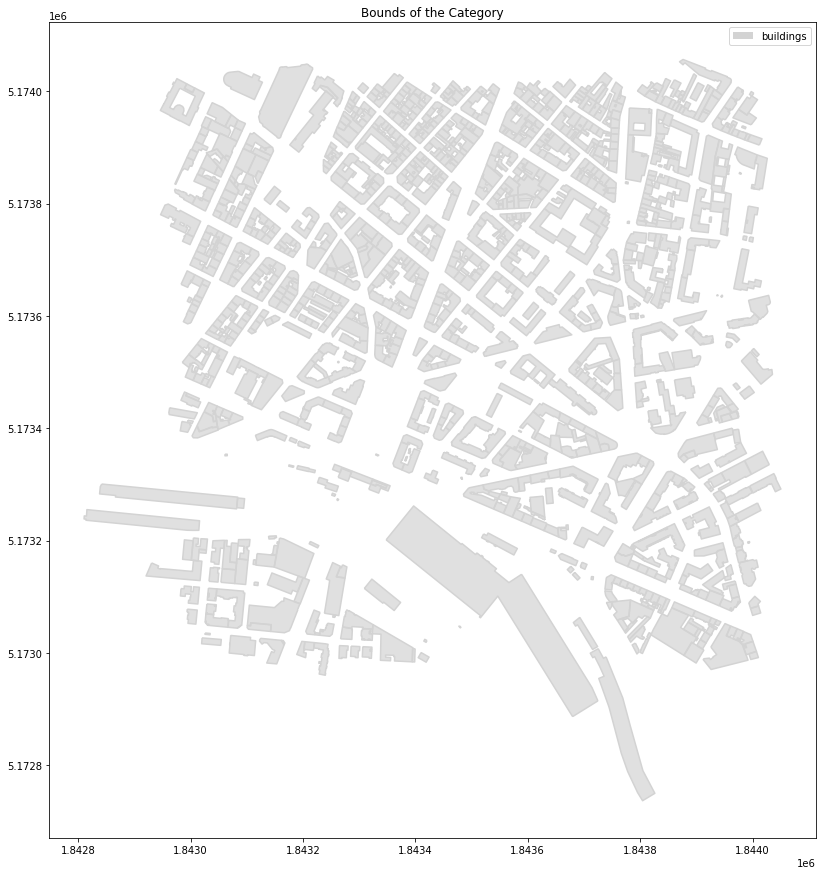

In [31]:
out_buildings.plot(figsize=(15, 15))

### Clip

The ``crop`` method does not modifies the polygons, meaning that a polygon that have points in the bounding box will not be removed. To modify polygons' geometry, and get only points / parts of polygons in a bounding box, you can use the ``clip`` method.

In [32]:
out_buildings = buildings.clip(image.bounds)
out_buildings

Category(data=GeoDataFrame(1384 rows, 3 columns), name='buildings', color=(211, 211, 211), crs=EPSG:3946)

<AxesSubplot:title={'center':'Bounds of the Category'}>

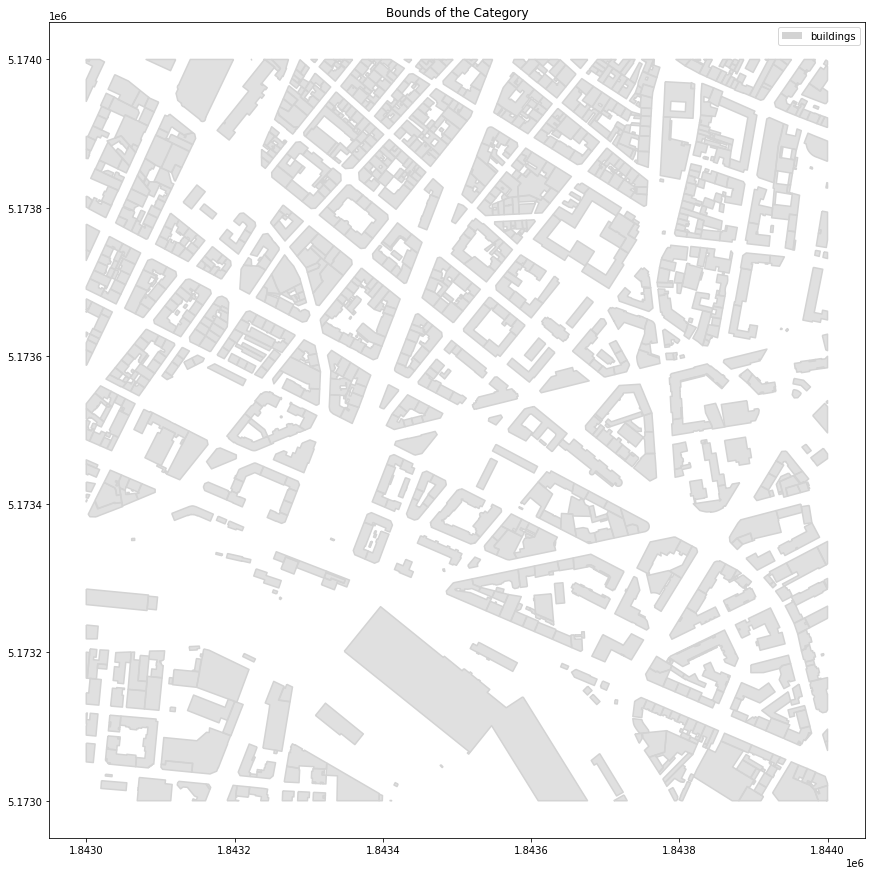

In [33]:
out_buildings.plot(figsize=(15, 15))

### Simplify

Finally, it is possible to clean the geometries by removing small polygons and merging overlapping ones.

In [37]:
out_buildings = buildings.simplify(min_area=25)
out_buildings

Category(data=GeoDataFrame(1394 rows, 1 columns), name='buildings', color=(211, 211, 211), crs=EPSG:3946)

You should note that there are less geometries in the resulting categories.

<AxesSubplot:title={'center':'Bounds of the Category'}>

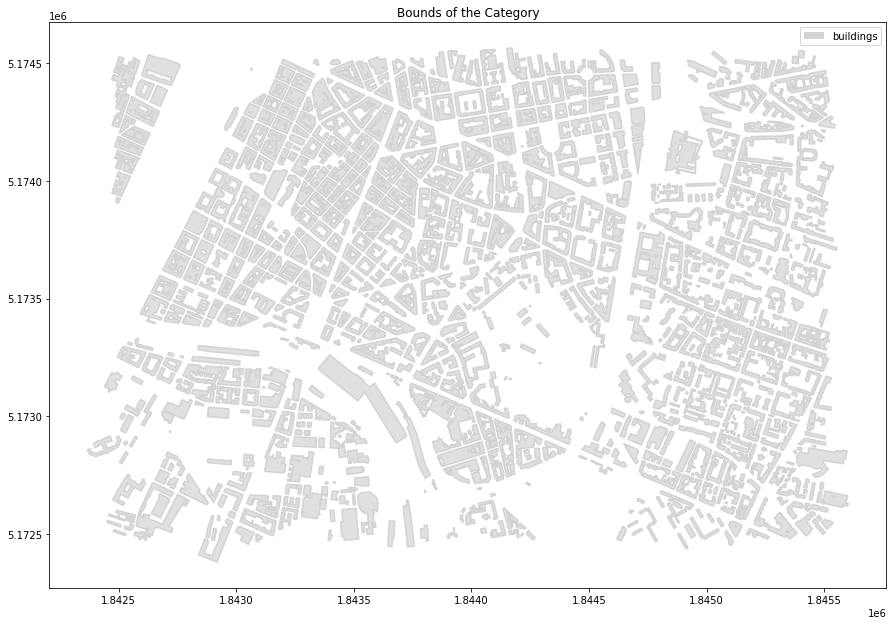

In [36]:
out_buildings.plot(figsize=(15, 15))